In [57]:
%config Completer.use_jedi = False
import pandas as pd
from sklearn.metrics import precision_recall_curve
from model import Cat_Dog
import torch
import cv2 
from utils import refactor_weights, image_preprocess, sft 
import glob
import timm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,recall_score, f1_score
import seaborn as sns

#  Метрики для анализа точности модельки 
## Precision, Recall and f1score theory 

for cat: dog - 0, cat - 1, for dog: cat - 0, dog - 1

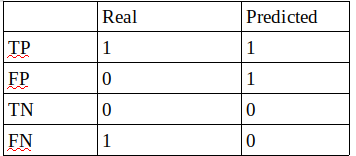

PRECISION is the portion of predicted ones that are realy one. RECALL is the portion of real ones that are predicted as ones. Therefore, looking at this table:

    PRECISION = TP / (TP + FP)
    RECALL = TP / (TP + FN)
    F1SCORE = 2 * PRECISON * RECALL / (PRECISION + RECALL)

In [88]:
#calculate precision and recall
def calc_metrics(true, pred):
    TP = FP = TN = FN = 0
    for idx in range(len(pred)):
        if true[idx] == pred[idx] ==1:
            TP +=1 
        if true[idx] != pred[idx] and pred[idx] ==1:
            FP +=1
        if true[idx]!= pred[idx] and pred[idx] == 0:
            FN +=1
    try:
        prec = TP/(TP+FP)
    except:
        prec = 1
    try:
        recall =  TP/(TP+FN)
    except:
        recall = 1
    
    return prec, recall 

In [104]:
model =Cat_Dog()
weights = torch.load('weights/CatDog_epoch=188_train_loss=0.2179_val_loss=0.2807.ckpt', map_location = 'cpu')['state_dict']

weights = refactor_weights(weights)
model.load_state_dict(weights)
model.eval()

test_image_list = list(glob.iglob('data/test/*.jpg', recursive = True))
true = [1 if 'd' in filename.split('/')[-1] else 0 for filename in test_image_list]
# 1 for dog and 0 for cat
pred = []
precision_scores  = []
recall_scores = []

with torch.no_grad():
    for image_path in test_image_list:
        model_in = image_preprocess(cv2.imread(image_path))
        output = model(model_in)
        cat_prob, dog_prob = sft(output, dim=1)[0].tolist()
        dog_prob =  int(round(dog_prob,0))
        #print(cat_prob, dog_prob)
        pred.append(dog_prob)
        
        prec, recall = calc_metrics(true, pred)
        
        precision_scores.append(prec)
        recall_scores.append(recall)

    

In [105]:
model = timm.create_model('efficientnet_b0', num_classes=2)
weights = torch.load(
         'weights/CatDog_epoch=61_val_loss=0.0585_val_acc=0.9848.ckpt', map_location = 'cpu')[
         'state_dict']

weights = refactor_weights(weights)
model.load_state_dict(weights)
model.eval()

test_image_list = list(glob.iglob('data/test/*.jpg', recursive = True))
true = [1 if 'd' in filename.split('/')[-1] else 0 for filename in test_image_list]
# 1 for dog and 0 for cat
pred1 = []
precision_scores1  = []
recall_scores1 = []

with torch.no_grad():
    for image_path in test_image_list:
        model_in = image_preprocess(cv2.imread(image_path))
        output = model(model_in)
        cat_prob, dog_prob = sft(output, dim=1)[0].tolist()
        dog_prob =  int(round(dog_prob,0))
        #print(cat_prob, dog_prob)
        pred1.append(dog_prob)
        
        prec, recall = calc_metrics(true, pred1)
        
        precision_scores1.append(prec)
        recall_scores1.append(recall)

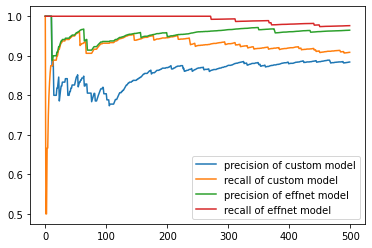

In [146]:
#plot 1:

plt.plot(precision_scores, label = 'precision of custom model')
plt.plot(recall_scores, label = 'recall of custom model')
plt.plot(precision_scores1, label = 'precision of effnet model')
plt.plot(recall_scores1, label = 'recall of effnet model')
plt.legend()
plt.show()


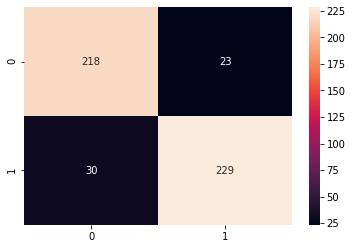

In [158]:
cm = confusion_matrix(pred, true)
# 1 for dog, 0 for cat 
plt = sns.heatmap(cm, annot = True, robust = True,fmt ='d')
#CUSTOM MODEL CONFUSION MATRIX

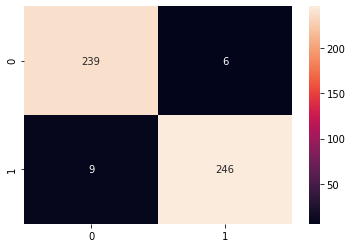

In [119]:
cm1 = confusion_matrix(pred1, true)
plt =sns.heatmap(cm1, annot = True, robust = True,fmt ='d')
#EFFNET CONFUSION MATRIX